# Hyperparameter Tuning by Grid-Search

In the previous notebook, we saw that hyperparameters can affect the generalization performance of a model. In this notebook, we will show how to optimize hyperparameters using  grid-search approach

## Our Predictive Model

Let's reload the dataset as we did previously:

In [1]:
import pandas as pd

from sklearn import set_config
set_config(display="diagram")

In [2]:
df = pd.read_csv('data/adult-census.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
target = df['class']
data = df.drop(columns=['class', 'education-num', 'fnlwgt'])

Once the dataset is loaded, we split it into a training and testing sets.

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
data_train, data_test, target_train, target_test = train_test_split(data, target,
                                                                   random_state=42)

We will define a pipeline as seen in the first module. It will handle both numerical and categorical features.  
The first step is to select all the categorical columns.

In [6]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include='object')
categorical_columns = categorical_columns_selector(data)

Here we will use a tree-based model as a classifier (i.e `HisGradientBoostingClassifier`). That means:

* Numerical variables don't need scaling;
* Categorical variables can be dealt with an `OrdinalEncoder` even if the coding order is not meaningful;
* For tree-based models, the `OrdinaleEncoder` avoids having high-dimensional representations.

We now build our `OrdinalEncoder` by passing it the known categories.

In [7]:
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value", 
                                          unknown_value=-1)

We then use a `ColumnTransformer` to select the categorical columns and apply the `OrdinalEncoder` to them.

In [8]:
from sklearn.compose import ColumnTransformer

In [9]:
preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)

Finally, we use a tree-based classifier (i.e. histogram gradient-boosting) to predict whether or not a person earns more than 50k\\$ a year.

In [10]:
# for the moment this line is reuqired to import HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

In [11]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4))
])

In [12]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

## Tuning Using a Grid-Search

In the previous exercise we use one `for` loop for each hyperparameter to find the best combination over a fixed grid of values.  
`GridSearchCV` is a scikit-learn class that implements a very similar logic with less repetitive code.  

Let's see how to use the `GridSearchCV` estimator for doing such search. Since grid-search will be costly, we will only explore the combination learning rate and the maximum number of nodes.

In [16]:
# Let's display our model parameters first:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__cat_preprocessor', 'preprocessor__cat_preprocessor__categories', 'preprocessor__cat_preprocessor__dtype', 'preprocessor__cat_preprocessor__handle_unknown', 'preprocessor__cat_preprocessor__unknown_value', 'classifier__categorical_features', 'classifier__early_stopping', 'classifier__l2_regularization', 'classifier__learning_rate', 'classifier__loss', 'classifier__max_bins', 'classifier__max_depth', 'classifier__max_iter', 'classifier__max_leaf_nodes', 'classifier__min_samples_leaf', 'classifier__monotonic_cst', 'classifier__n_iter_no_change', 'classifier__random_state', 'classifier__scoring', 'classifier__tol', 'classifier__validation_fraction', 'classifier__verbose', 'classifier__warm_start'])

In [17]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__learning_rate': (.01, .1, 1, 10),
    'classifier__max_leaf_nodes': (3, 10, 30)}

model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=2)
model_grid_search.fit(data_train, target_train)

CPU times: user 4.44 s, sys: 446 ms, total: 4.89 s
Wall time: 13.2 s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                                       random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': (0.01, 0.1, 1, 10),
                         'classifier__max_leaf_nodes': (3, 10, 30)})

Finally, we will check the accuracy of our model using the test set.

In [18]:
accuracy = model_grid_search.score(data_test, target_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.88


<div class="alert alert-block alert-warning">
<b>Warning:</b> Be aware that evaluation should normally be performed in a cross-validation framework by providing <em>model_grid_search</em> as a model to the <em>cross_validate</em> function.
</div>

The `GridSearchCV` estimator takes a `param_grid` parameter which defines all hyperparameters and their associated values. The grid-search will be in charge of creating all possible combinations and test them.

Once the grid-search is fitted, it can be used as any other predictor by calling `predict` and `predict_proba`. Internally, it will use the model with the best parameters found during `fit`.

Get predictions for the 5 first samples using the estimator with the best parameters.

In [19]:
model_grid_search.predict(data_test[:5])

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' >50K'], dtype=object)

In [21]:
print(target_test[:5])

7762      <=50K
23881     <=50K
30507      >50K
28911     <=50K
19484     <=50K
Name: class, dtype: object


You can know about these parameters by looking at the `best_params_` attribute.

In [22]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 30}


We can inspect all results which are stored in the attribute `cv_results_` of the grid-search. We will filter some specific columns from these results.

In [23]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
                "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
5,1.052601,0.103182,0.225852,0.001325,0.1,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.868912,0.867213,0.868063,0.000850,1
4,0.666612,0.005010,0.222016,0.005603,0.1,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.866783,0.866066,0.866425,0.000359,2
7,0.231507,0.001739,0.165190,0.021626,1,10,"{'classifier__learning_rate': 1, 'classifier__...",0.854826,0.862899,0.858863,0.004036,3
6,0.282346,0.050397,0.152330,0.004046,1,3,"{'classifier__learning_rate': 1, 'classifier__...",0.853844,0.860934,0.857389,0.003545,4
3,0.812848,0.022379,0.199927,0.005853,0.1,3,"{'classifier__learning_rate': 0.1, 'classifier...",0.852752,0.853781,0.853266,0.000515,5


Let us focus on the most interesting columns and shorten the parameter names to remove the "param_classifier__" prefix for readability:

In [24]:
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [25]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
5,0.1,30,0.868063,0.000850,1
4,0.1,10,0.866425,0.000359,2
7,1,10,0.858863,0.004036,3
6,1,3,0.857389,0.003545,4
3,0.1,3,0.853266,0.000515,5
8,1,30,0.851028,0.002707,6
2,0.01,30,0.843330,0.002917,7
1,0.01,10,0.817832,0.001124,8
0,0.01,3,0.797166,0.000715,9
10,10,10,0.618080,0.124277,10


With only 2 parameters, we might want to visualize the grid-search as a heatmap.  
We need to transform our `cv_results` into a dataframe where:

* the rows will correspond to the learning-rate values;
* the columns will correspond to the maximum number of leaf;
* the content of the dataframe will be the mean test scores.

In [26]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results

max_leaf_nodes,3,10,30
learning_rate,,,
0.01,0.797166,0.817832,0.843330
0.10,0.853266,0.866425,0.868063
1.00,0.857389,0.858863,0.851028
10.00,0.283476,0.618080,0.549338


We can use a heatmap representation to show the above dataframe visually.

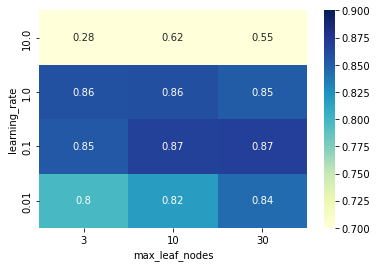

In [27]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()

The above tables highlights the following things:

* for too high values of `learning_rate`, the generalization performance of the model is degraded and adjusting the value of `max_leaf_nodes` cannot fix that problem;
* outside of this pathological region, we observe that the optimal choice of `max_leaf_nodes` depends on the value of `learning_rat`e;
* in particular, we observe a “diagonal” of good models with an accuracy close to the maximal of 0.87: when the value of `max_leaf_nodes` is increased, one should decrease the value of `learning_rate` accordingly to preserve a good accuracy.

<div class="alert alert-block alert-info">
<b>Note:</b> In general there is no unique optimal parameter setting!.</div>